In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_about'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5497661152990853 	 Validation loss: 0.3957246557130652 	 
  1%|          | 574/57400 [01:35<2:25:19,  6.52it/s]
Epoch 2 	 Training loss: 0.39883073707490846 	 Validation loss: 0.35638570103604916 	 
  2%|▏         | 1148/57400 [03:12<2:28:22,  6.32it/s]
Epoch 3 	 Training loss: 0.3660197494752731 	 Validation loss: 0.33627340500637637 	 
  3%|▎         | 1722/57400 [04:49<2:50:45,  5.43it/s]
Epoch 4 	 Training loss: 0.3472488414794726 	 Validation loss: 0.3244367226705713 	 
  4%|▍         | 2296/57400 [06:25<2:19:32,  6.58it/s]
Epoch 5 	 Training loss: 0.33331470978073124 	 Validation loss: 0.31663726522760877 	 
  5%|▌         | 2870/57400 [08:02<2:17:50,  6.59it/s]
Epoch 6 	 Training loss: 0.3215775922044644 	 Validation loss: 0.3163304114240711 	 
  6%|▌         | 3444/57400 [09:39<2:26:07,  6.15it/s]
Epoch 7 	 Training loss: 0.31358551657158323 	 Validation loss: 0.30716109402098896 	 
  7%|▋         | 4018/57400 [11:16<2:35:38,  5.72it/s]
Epoch 8 	 Trai

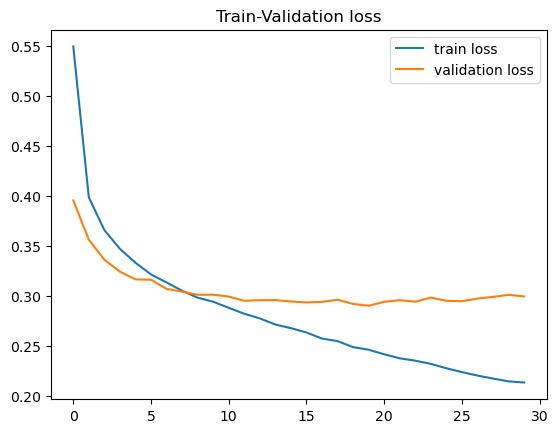

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8635204081632653, 'precision': 0.8635204081632653, 'f1': 0.8635204081632653, 'accuracy': 0.8635204081632653}
MALE {'recall': 0.8671875, 'precision': 0.8671875, 'f1': 0.8671875, 'accuracy': 0.8671875}
FEMALE {'recall': 0.86, 'precision': 0.86, 'f1': 0.8599999999999999, 'accuracy': 0.86} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7007575757575758, 'precision': 0.7007575757575758, 'f1': 0.7007575757575758, 'accuracy': 0.7007575757575758}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6910039113428944, 'precision': 0.6910039113428944, 'f1': 0.6910039113428944, 'accuracy': 0.6910039113428944}
MALE {'recall': 0.7045454545454546, 'precision': 0

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5656746238573919 	 Validation loss: 0.4002223828081357 	 
  1%|          | 574/57400 [01:57<2:37:00,  6.03it/s]
Epoch 2 	 Training loss: 0.39886058944858327 	 Validation loss: 0.35840800960185165 	 
  2%|▏         | 1148/57400 [03:35<2:42:56,  5.75it/s]
Epoch 3 	 Training loss: 0.3666454612274203 	 Validation loss: 0.33731018537181917 	 
  3%|▎         | 1722/57400 [05:14<2:52:07,  5.39it/s]
Epoch 4 	 Training loss: 0.3462713736430693 	 Validation loss: 0.32866665771452047 	 
  4%|▍         | 2296/57400 [06:52<2:33:49,  5.97it/s]
Epoch 5 	 Training loss: 0.33385558935200293 	 Validation loss: 0.3227063748290983 	 
  5%|▌         | 2870/57400 [08:31<2:14:56,  6.74it/s]
Epoch 6 	 Training loss: 0.32536700578205263 	 Validation loss: 0.3165181731268511 	 
  6%|▌         | 3444/57400 [10:10<2:29:07,  6.03it/s]
Epoch 7 	 Training loss: 0.31448531392247836 	 Validation loss: 0.31314260045350606 	 
  7%|▋         | 4018/57400 [11:48<2:23:22,  6.21it/s]
Epoch 8 	 Tra

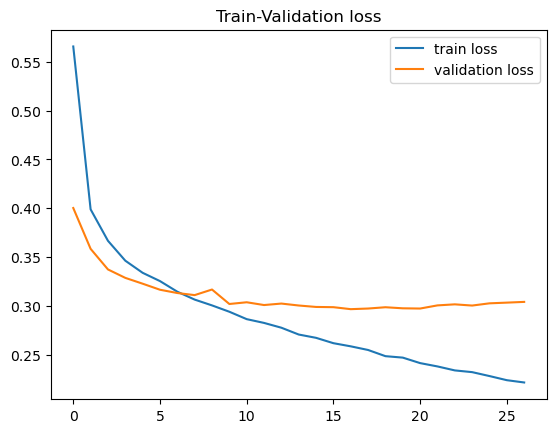

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8533163265306123, 'precision': 0.8533163265306123, 'f1': 0.8533163265306123, 'accuracy': 0.8533163265306123}
MALE {'recall': 0.8671875, 'precision': 0.8671875, 'f1': 0.8671875, 'accuracy': 0.8671875}
FEMALE {'recall': 0.84, 'precision': 0.84, 'f1': 0.8399999999999999, 'accuracy': 0.84} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7070707070707071, 'precision': 0.7070707070707071, 'f1': 0.7070707070707071, 'accuracy': 0.7070707070707071}
MALE {'recall': 0.7226277372262774, 'precision': 0.7226277372262774, 'f1': 0.7226277372262774, 'accuracy': 0.7226277372262774}
FEMALE {'recall': 0.6902887139107612, 'precision': 0.6902887139107612, 'f1': 0.6902887139107612, 'accuracy': 0.6902887139107612} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6883963494132985, 'precision': 0.6883963494132985, 'f1': 0.6883963494132985, 'accuracy': 0.6883963494132985}
MALE {'recall': 0.7095959595959596, 'precision

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5573266460089733 	 Validation loss: 0.3918024463168645 	 
  1%|          | 574/57400 [01:54<2:38:43,  5.97it/s]
Epoch 2 	 Training loss: 0.39778866849917566 	 Validation loss: 0.352128924959797 	 
  2%|▏         | 1148/57400 [03:44<2:49:31,  5.53it/s]
Epoch 3 	 Training loss: 0.3669858121861564 	 Validation loss: 0.3342190948078188 	 
  3%|▎         | 1722/57400 [05:36<2:49:51,  5.46it/s]
Epoch 4 	 Training loss: 0.3471465334036624 	 Validation loss: 0.3323119484772116 	 
  4%|▍         | 2296/57400 [07:27<2:41:04,  5.70it/s]
Epoch 5 	 Training loss: 0.3346418966295827 	 Validation loss: 0.3271694074747926 	 
  5%|▌         | 2870/57400 [09:19<2:37:35,  5.77it/s]
Epoch 6 	 Training loss: 0.3250710443181443 	 Validation loss: 0.31166506369235153 	 
  6%|▌         | 3444/57400 [11:11<2:49:44,  5.30it/s]
Epoch 7 	 Training loss: 0.315014439047629 	 Validation loss: 0.3090782630241523 	 
  7%|▋         | 4018/57400 [13:04<2:25:50,  6.10it/s]
Epoch 8 	 Training lo

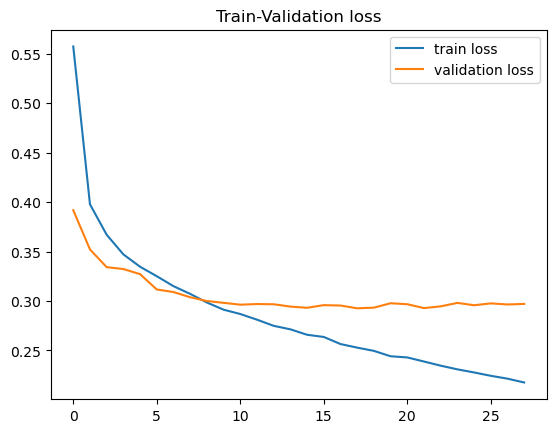

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8584183673469388, 'precision': 0.8584183673469388, 'f1': 0.8584183673469388, 'accuracy': 0.8584183673469388}
MALE {'recall': 0.859375, 'precision': 0.859375, 'f1': 0.859375, 'accuracy': 0.859375}
FEMALE {'recall': 0.8575, 'precision': 0.8575, 'f1': 0.8575, 'accuracy': 0.8575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.702020202020202, 'precision': 0.702020202020202, 'f1': 0.702020202020202, 'accuracy': 0.702020202020202}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6831812255541069, 'precision': 0.6831812255541069, 'f1': 0.6831812255541069, 'accuracy': 0.6831812255541069}
MALE {'recall': 0.6994949494949495, 'precision': 0.6994949494949

Resultados finales

In [24]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8584183673469388, 'precision': 0.8584183673469388, 'f1': 0.8584183673469388, 'accuracy': 0.8584183673469388}
Métricas etiqueta male: {'recall': 0.8645833333333334, 'precision': 0.8645833333333334, 'f1': 0.8645833333333334, 'accuracy': 0.8645833333333334}
Métricas etiqueta female:  {'recall': 0.8525, 'precision': 0.8525, 'f1': 0.8524999999999999, 'accuracy': 0.8525}

 to
Resultado global: {'recall': 0.7032828282828283, 'precision': 0.7032828282828283, 'f1': 0.7032828282828283, 'accuracy': 0.7032828282828283}
Métricas etiqueta male: {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289538, 'accuracy': 0.7128953771289538}
Métricas etiqueta female:  {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716}

 as
Resultado global: {'recall': 0.6875271621034332, 'precision': 0.6875271621034332, 'f1': 0.6875271621034332, 'accuracy': 0.68752

# TO

In [25]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934832413437475 	 Validation loss: 0.6929771304130554 	 
  1%|          | 574/57400 [01:43<2:43:13,  5.80it/s]
Epoch 2 	 Training loss: 0.6934590140286223 	 Validation loss: 0.6931277281146938 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:26<2:27:31,  6.35it/s]
Epoch 3 	 Training loss: 0.6934696160750107 	 Validation loss: 0.6927295892925586 	 
  3%|▎         | 1722/57400 [05:09<2:32:02,  6.10it/s]
Epoch 4 	 Training loss: 0.6934063417986295 	 Validation loss: 0.6922119199219396 	 
  4%|▍         | 2296/57400 [06:53<2:20:19,  6.55it/s]
Epoch 5 	 Training loss: 0.6931835942567434 	 Validation loss: 0.6930203599444891 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:36<2:30:10,  6.05it/s]
Epoch 6 	 Training loss: 0.6932780276399871 	 Validation loss: 0.6928463850991201 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:18<2:29:09,  6.03it/s]
Epoch 7 	 Training loss: 0.6930295012969173 	 Validation loss: 0.693066509

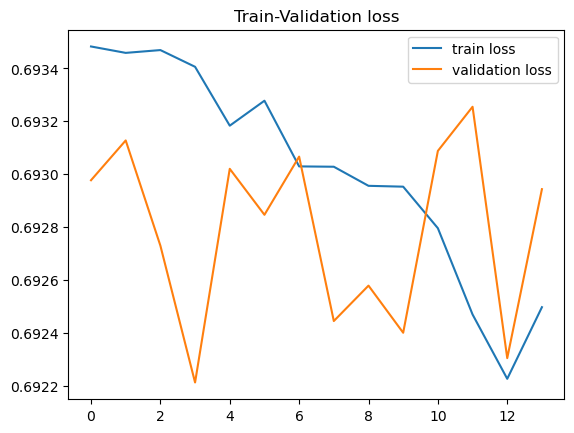

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5395408163265306, 'precision': 0.5395408163265306, 'f1': 0.5395408163265306, 'accuracy': 0.5395408163265306}
MALE {'recall': 0.1796875, 'precision': 0.1796875, 'f1': 0.1796875, 'accuracy': 0.1796875}
FEMALE {'recall': 0.885, 'precision': 0.885, 'f1': 0.885, 'accuracy': 0.885} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.49242424242424243, 'precision': 0.49242424242424243, 'f1': 0.49242424242424243, 'accuracy': 0.49242424242424243}
MALE {'recall': 0.19708029197080293, 'precision': 0.19708029197080293, 'f1': 0.19708029197080296, 'accuracy': 0.19708029197080293}
FEMALE {'recall': 0.8110236220472441, 'precision': 0.8110236220472441, 'f1': 0.8110236220472442, 'accuracy': 0.8110236220472441} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5071707953063885, 'precision': 0.5071707953063885, 'f1': 0.5071707953063885, 'accuracy': 0.5071707953063885}
MALE {'recall': 0.2196969696969697, 'precision':

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955038873991485 	 Validation loss: 0.6923695277359526 	 
  1%|          | 574/57400 [01:43<2:28:09,  6.39it/s]
Epoch 2 	 Training loss: 0.6948600423876001 	 Validation loss: 0.6928975501302945 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:25<2:43:01,  5.75it/s]
Epoch 3 	 Training loss: 0.6946471594144243 	 Validation loss: 0.6925277497808812 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:07<2:35:05,  5.98it/s]
Epoch 4 	 Training loss: 0.6946010179428274 	 Validation loss: 0.6929779163861679 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [06:50<2:36:16,  5.88it/s]
Epoch 5 	 Training loss: 0.6947774508065878 	 Validation loss: 0.6931136593980304 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [08:32<2:10:57,  6.94it/s]
Epoch 6 	 Training loss: 0.6947817887578692 	 Validation loss: 0.6931718365620758 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [10:15<2:38:01,  5.69it/s]
Epoch 7 	 Traini

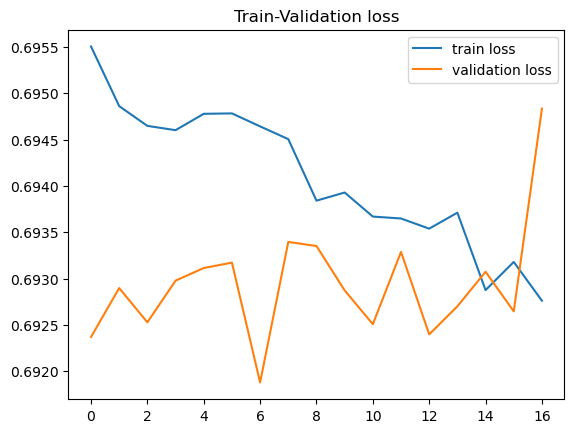

In [28]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5114795918367347, 'precision': 0.5114795918367347, 'f1': 0.5114795918367347, 'accuracy': 0.5114795918367347}
MALE {'recall': 0.11197916666666667, 'precision': 0.11197916666666667, 'f1': 0.11197916666666667, 'accuracy': 0.11197916666666667}
FEMALE {'recall': 0.895, 'precision': 0.895, 'f1': 0.895, 'accuracy': 0.895} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5063131313131313, 'precision': 0.5063131313131313, 'f1': 0.5063131313131313, 'accuracy': 0.5063131313131313}
MALE {'recall': 0.12652068126520682, 'precision': 0.12652068126520682, 'f1': 0.12652068126520682, 'accuracy': 0.12652068126520682}
FEMALE {'recall': 0.916010498687664, 'precision': 0.916010498687664, 'f1': 0.916010498687664, 'accuracy': 0.916010498687664} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5019556714471969, 'precision': 0.5019556714471969, 'f1': 0.5019556714471969, 'accuracy': 0.5019556714471969}
MALE {'recall': 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6939077716878898 	 Validation loss: 0.6927570983514948 	 
  1%|          | 574/57400 [01:42<2:51:05,  5.54it/s]
Epoch 2 	 Training loss: 0.6934407905834478 	 Validation loss: 0.6932902992781946 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:25<2:24:10,  6.50it/s]
Epoch 3 	 Training loss: 0.6934147574760358 	 Validation loss: 0.6926971845707651 	 
  3%|▎         | 1722/57400 [05:08<2:17:46,  6.74it/s]
Epoch 4 	 Training loss: 0.6936088930231353 	 Validation loss: 0.6927260877722401 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:51<2:38:33,  5.79it/s]
Epoch 5 	 Training loss: 0.693386387430417 	 Validation loss: 0.6928392194085202 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:33<2:25:15,  6.26it/s]
Epoch 6 	 Training loss: 0.6933641221880498 	 Validation loss: 0.6927369792582625 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:15<2:30:54,  5.96it/s]
Epoch 7 	 Training loss: 0.6930115985122707 	 

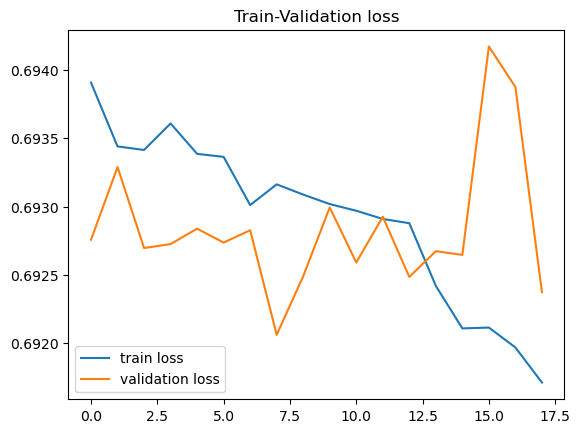

In [30]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [31]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5229591836734694, 'precision': 0.5229591836734694, 'f1': 0.5229591836734694, 'accuracy': 0.5229591836734694}
MALE {'recall': 0.07552083333333333, 'precision': 0.07552083333333333, 'f1': 0.07552083333333333, 'accuracy': 0.07552083333333333}
FEMALE {'recall': 0.9525, 'precision': 0.9525, 'f1': 0.9525, 'accuracy': 0.9525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4936868686868687, 'precision': 0.4936868686868687, 'f1': 0.4936868686868687, 'accuracy': 0.4936868686868687}
MALE {'recall': 0.06569343065693431, 'precision': 0.06569343065693431, 'f1': 0.06569343065693431, 'accuracy': 0.06569343065693431}
FEMALE {'recall': 0.9553805774278216, 'precision': 0.9553805774278216, 'f1': 0.9553805774278216, 'accuracy': 0.9553805774278216} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49934810951760106, 'precision': 0.49934810951760106, 'f1': 0.49934810951760106, 'accuracy': 0.49934810951760106}
MALE

Resultados finales

In [32]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5246598639455783, 'precision': 0.5246598639455783, 'f1': 0.5246598639455783, 'accuracy': 0.5246598639455783}
Métricas etiqueta male: {'recall': 0.12239583333333333, 'precision': 0.12239583333333333, 'f1': 0.12239583333333333, 'accuracy': 0.12239583333333333}
Métricas etiqueta female:  {'recall': 0.9108333333333334, 'precision': 0.9108333333333334, 'f1': 0.9108333333333334, 'accuracy': 0.9108333333333334}

 to
Resultado global: {'recall': 0.49747474747474746, 'precision': 0.49747474747474746, 'f1': 0.49747474747474746, 'accuracy': 0.49747474747474746}
Métricas etiqueta male: {'recall': 0.12976480129764803, 'precision': 0.12976480129764803, 'f1': 0.12976480129764803, 'accuracy': 0.12976480129764803}
Métricas etiqueta female:  {'recall': 0.8941382327209099, 'precision': 0.8941382327209099, 'f1': 0.89413823272091, 'accuracy': 0.8941382327209099}

 as
Resultado global: {'recall': 0.5028248587570622, 'precision': 0.5028248587570622,

# AS

In [33]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948174497807067 	 Validation loss: 0.6934992378040895 	 
  1%|          | 574/57400 [01:42<2:40:42,  5.89it/s]
Epoch 2 	 Training loss: 0.6934153423076723 	 Validation loss: 0.6915440306825152 	 
  2%|▏         | 1148/57400 [03:25<2:37:22,  5.96it/s]
Epoch 3 	 Training loss: 0.6909546103419327 	 Validation loss: 0.6904685103287131 	 
  3%|▎         | 1722/57400 [05:08<2:50:23,  5.45it/s]
Epoch 4 	 Training loss: 0.6893544877240051 	 Validation loss: 0.6909543690034898 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:50<2:51:23,  5.36it/s]
Epoch 5 	 Training loss: 0.6878422382401257 	 Validation loss: 0.6926608075529842 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:33<2:32:08,  5.97it/s]
Epoch 6 	 Training loss: 0.685899671257996 	 Validation loss: 0.6917676147768053 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:15<2:34:05,  5.84it/s]
Epoch 7 	 Training loss: 0.6841151264694094 	 Validation loss: 0.6924018233

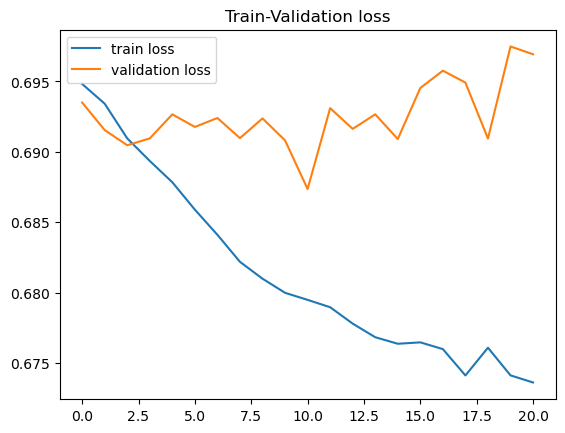

In [34]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6772959183673469, 'precision': 0.6772959183673469, 'f1': 0.6772959183673469, 'accuracy': 0.6772959183673469}
MALE {'recall': 0.703125, 'precision': 0.703125, 'f1': 0.703125, 'accuracy': 0.703125}
FEMALE {'recall': 0.6525, 'precision': 0.6525, 'f1': 0.6525, 'accuracy': 0.6525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7348484848484849, 'precision': 0.7348484848484849, 'f1': 0.7348484848484848, 'accuracy': 0.7348484848484849}
MALE {'recall': 0.8150851581508516, 'precision': 0.8150851581508516, 'f1': 0.8150851581508516, 'accuracy': 0.8150851581508516}
FEMALE {'recall': 0.6482939632545932, 'precision': 0.6482939632545932, 'f1': 0.6482939632545932, 'accuracy': 0.6482939632545932} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7940026075619296, 'precision': 0.7940026075619296, 'f1': 0.7940026075619296, 'accuracy': 0.7940026075619296}
MALE {'recall': 0.7878787878787878, 'precision': 0.78787

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6939829452943304 	 Validation loss: 0.6935769905478267 	 
  1%|          | 574/57400 [01:41<2:36:50,  6.04it/s]
Epoch 2 	 Training loss: 0.693588610517854 	 Validation loss: 0.6929691585443788 	 
  2%|▏         | 1148/57400 [03:24<2:36:10,  6.00it/s]
Epoch 3 	 Training loss: 0.6927392562715019 	 Validation loss: 0.6914723515510559 	 
  3%|▎         | 1722/57400 [05:07<2:21:58,  6.54it/s]
Epoch 4 	 Training loss: 0.6893822417857339 	 Validation loss: 0.6924460479768656 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:50<2:45:03,  5.56it/s]
Epoch 5 	 Training loss: 0.6873517809013872 	 Validation loss: 0.6907339540578551 	 
  5%|▌         | 2870/57400 [08:33<2:32:15,  5.97it/s]
Epoch 6 	 Training loss: 0.6854609126413326 	 Validation loss: 0.6928802799370329 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:15<2:43:21,  5.50it/s]
Epoch 7 	 Training loss: 0.6833931966733434 	 Validation loss: 0.6918499419244669 	 

2 epoch without im

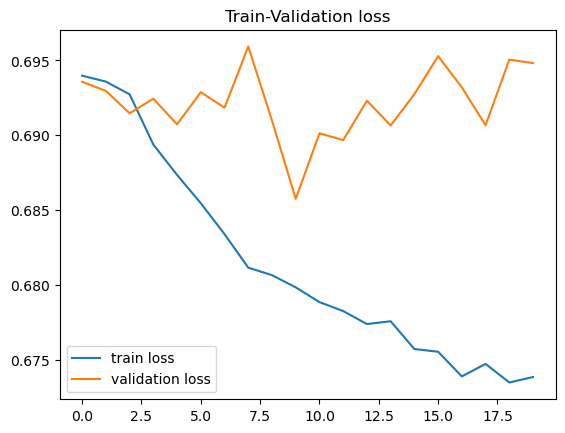

In [36]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6836734693877551, 'precision': 0.6836734693877551, 'f1': 0.6836734693877551, 'accuracy': 0.6836734693877551}
MALE {'recall': 0.75, 'precision': 0.75, 'f1': 0.75, 'accuracy': 0.75}
FEMALE {'recall': 0.62, 'precision': 0.62, 'f1': 0.62, 'accuracy': 0.62} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7474747474747475, 'precision': 0.7474747474747475, 'f1': 0.7474747474747475, 'accuracy': 0.7474747474747475}
MALE {'recall': 0.829683698296837, 'precision': 0.829683698296837, 'f1': 0.829683698296837, 'accuracy': 0.829683698296837}
FEMALE {'recall': 0.6587926509186351, 'precision': 0.6587926509186351, 'f1': 0.6587926509186351, 'accuracy': 0.6587926509186351} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.8200782268578879, 'precision': 0.8200782268578879, 'f1': 0.820078226857888, 'accuracy': 0.8200782268578879}
MALE {'recall': 0.8106060606060606, 'precision': 0.8106060606060606, 'f1': 0.81060606

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693815779914424 	 Validation loss: 0.6929003757945562 	 
  1%|          | 574/57400 [01:42<2:15:50,  6.97it/s]
Epoch 2 	 Training loss: 0.6935598232397219 	 Validation loss: 0.6936954886226331 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:25<2:33:41,  6.10it/s]
Epoch 3 	 Training loss: 0.6934812275582489 	 Validation loss: 0.6935315829212383 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:07<2:36:36,  5.93it/s]
Epoch 4 	 Training loss: 0.6926402092395344 	 Validation loss: 0.6926953378370253 	 
  4%|▍         | 2296/57400 [06:51<2:50:08,  5.40it/s]
Epoch 5 	 Training loss: 0.6900562297176401 	 Validation loss: 0.6935159553915767 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:33<2:43:45,  5.55it/s]
Epoch 6 	 Training loss: 0.6876912381798548 	 Validation loss: 0.691812481920598 	 
  6%|▌         | 3444/57400 [10:16<2:15:25,  6.64it/s]
Epoch 7 	 Training loss: 0.6866749152281558 	 Validation loss: 0.69018323946

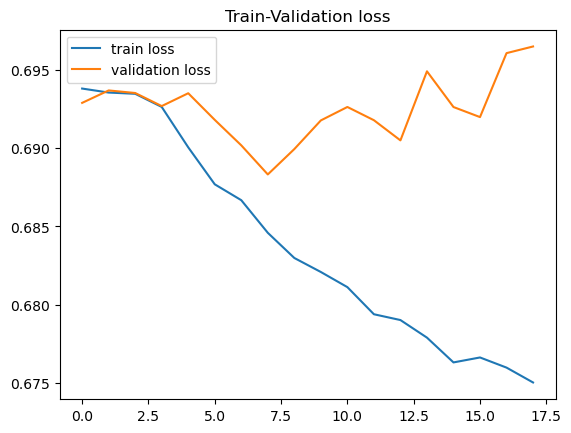

In [38]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_pos_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [39]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7117346938775511, 'precision': 0.7117346938775511, 'f1': 0.7117346938775511, 'accuracy': 0.7117346938775511}
MALE {'recall': 0.6979166666666666, 'precision': 0.6979166666666666, 'f1': 0.6979166666666666, 'accuracy': 0.6979166666666666}
FEMALE {'recall': 0.725, 'precision': 0.725, 'f1': 0.7250000000000001, 'accuracy': 0.725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7108585858585859, 'precision': 0.7108585858585859, 'f1': 0.7108585858585859, 'accuracy': 0.7108585858585859}
MALE {'recall': 0.7347931873479319, 'precision': 0.7347931873479319, 'f1': 0.7347931873479319, 'accuracy': 0.7347931873479319}
FEMALE {'recall': 0.6850393700787402, 'precision': 0.6850393700787402, 'f1': 0.6850393700787402, 'accuracy': 0.6850393700787402} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7666232073011734, 'precision': 0.7666232073011734, 'f1': 0.7666232073011734, 'accuracy': 0.7666232073011734}
MALE {'

Resultados finales

In [40]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6909013605442177, 'precision': 0.6909013605442177, 'f1': 0.6909013605442177, 'accuracy': 0.6909013605442177}
Métricas etiqueta male: {'recall': 0.7170138888888888, 'precision': 0.7170138888888888, 'f1': 0.7170138888888888, 'accuracy': 0.7170138888888888}
Métricas etiqueta female:  {'recall': 0.6658333333333333, 'precision': 0.6658333333333333, 'f1': 0.6658333333333334, 'accuracy': 0.6658333333333333}

 to
Resultado global: {'recall': 0.7310606060606061, 'precision': 0.7310606060606061, 'f1': 0.7310606060606061, 'accuracy': 0.7310606060606061}
Métricas etiqueta male: {'recall': 0.7931873479318735, 'precision': 0.7931873479318735, 'f1': 0.7931873479318735, 'accuracy': 0.7931873479318735}
Métricas etiqueta female:  {'recall': 0.6640419947506562, 'precision': 0.6640419947506562, 'f1': 0.6640419947506562, 'accuracy': 0.6640419947506562}

 as
Resultado global: {'recall': 0.7935680139069969, 'precision': 0.7935680139069969, 'f1': 0.7